In [1]:
from coinor.grumpy.polyhedron2D import Polyhedron2D, Figure
import gurobipy as gu
import numpy as np

In [2]:
# utility function to get the model as np arrays
def get_model_arrays(mdl):
    
    # we assume that the model is Ax >= b
    for c in mdl.getConstrs():
        if c.sense == gu.GRB.LESS_EQUAL:
            c.setAttr(gu.GRB.Attr.Sense, gu.GRB.GREATER_EQUAL)
            c.setAttr(gu.GRB.Attr.RHS, -c.rhs)
    
    # get the constraints
    A = mdl.getA().toarray()
    b = np.array([c.rhs for c in mdl.getConstrs()])
    
    # get the finite lower bounds on variables
    Dlb, Dlb_0 = np.eye(mdl.numVars), np.array([v.lb for v in mdl.getVars()])
    Dlb, Dlb_0 = Dlb[Dlb_0 > -np.inf], Dlb_0[Dlb_0 > -np.inf]
    
    # get the finite upper bounds on variables
    Dub, Dub_0 = -np.eye(mdl.numVars), -np.array([v.ub for v in mdl.getVars()])
    Dub, Dub_0 = Dub[Dub_0 > -np.inf], Dub_0[Dub_0 > -np.inf]
    
    # merge the variable bounds into a single matrix with the constraints
    A = np.vstack([A, Dlb, Dub])
    b = np.hstack([b, Dlb_0, Dub_0])
    
    # get the objective function
    c = np.array([v.obj for v in mdl.getVars()])
    
    return A, b, c


# utility function to get the disjunctive constraints as np arrays
def get_disjunctive_constraint_arrays(mdl):
    
    # we assume that the model is Ax >= b
    for c in mdl.getConstrs():
        if c.sense == gu.GRB.LESS_EQUAL:
            c.setAttr(gu.GRB.Attr.Sense, gu.GRB.GREATER_EQUAL)
            c.setAttr(gu.GRB.Attr.RHS, -c.rhs)
    
    # get the disjunctive constraints from branching up
    Dlb, Dlb_0 = np.eye(mdl.numVars), np.array([v.lb for v in mdl.getVars()])
    Dlb, Dlb_0 = Dlb[Dlb_0 > 0], Dlb_0[Dlb_0 > 0]
    
    # get the disjunctive constraints from branching down
    Dub, Dub_0 = -np.eye(mdl.numVars), -np.array([v.ub for v in mdl.getVars()])
    Dub, Dub_0 = Dub[Dub_0 > -np.inf], Dub_0[Dub_0 > -np.inf]
    
    # merge the variable bounds into a single matrix with the constraints
    D = np.vstack([Dlb, Dub])
    D_0 = np.hstack([Dlb_0, Dub_0])
    
    return D, D_0

# Solve a first LP that becomes infeasible when branched on y >= 1

In [4]:
mdl = gu.Model("lp_minimize")

# Create variables
x = mdl.addVar(name="x")
y = mdl.addVar(name="y")
z = mdl.addVar(name="z")

# Set objective function: minimize x - y - 10z
mdl.setObjective(-x - y -z, gu.GRB.MINIMIZE)

# Add constraints
c0 = mdl.addConstr(-z >= -1, "c0")
c1 = mdl.addConstr(-x >= -1, "c1")
c2 = mdl.addConstr(-2*y - z >= -2, "c2")
c3 = mdl.addConstr(-x - 2*y >= -2, "c3")
c4 = mdl.addConstr(-2*y + z >= -1, "c4")
c5 = mdl.addConstr(x - 2*y >= -1, "c5")
mdl.update()

# get the model as np arrays
A0 = mdl.getA().toarray()
b0 = np.array([c.rhs for c in mdl.getConstrs()])
c0 = np.array([v.obj for v in mdl.getVars()])

# make sure this works
mdl.optimize()
x.x, y.x, z.x

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 3 columns and 10 nonzeros
Model fingerprint: 0x530a98fc
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 4 rows, 3 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0000000e+00   5.000000e-01   0.000000e+00      0s
       1   -2.5000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective -2.500000000e+00


(1.0, 0.5, 1.0)

In [5]:
# concatenate the identity matrix to the right of A0
I = np.eye(mdl.numConstrs, mdl.numConstrs)
full_A0 = np.hstack([A0, -I])
full_A0

array([[ 0.,  0., -1., -1., -0., -0., -0., -0., -0.],
       [-1.,  0.,  0., -0., -1., -0., -0., -0., -0.],
       [ 0., -2., -1., -0., -0., -1., -0., -0., -0.],
       [-1., -2.,  0., -0., -0., -0., -1., -0., -0.],
       [ 0., -2.,  1., -0., -0., -0., -0., -1., -0.],
       [ 1., -2.,  0., -0., -0., -0., -0., -0., -1.]])

# Maximize x to find out our basis cone for y >= 1

In [6]:
# Set objective function: minimize x
mdl.setObjective(y, gu.GRB.MAXIMIZE)

# find the new solution
mdl.optimize()
x.x, y.x, z.x

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 3 columns and 10 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+29   3.000000e+30   5.000000e-01      0s
       3    7.5000000e-01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.500000000e-01


(0.5, 0.75, 0.5)

In [7]:
# see which decision and slack variables are in the basis (i.e. are not at their bounds - marked by 0 value)
mdl.vBasis, mdl.cBasis

([0, 0, 0], [0, 0, -1, -1, -1, 0])

# Find the basis matrix so we can calculate reduced costs for the original objective at this solution

In [10]:
# create an empty containers to hold basis and nonbasis information
# basis is always m x m since matrix is always m x (n + m)
A_b = np.zeros((mdl.numConstrs, mdl.numConstrs))
A_n = np.zeros((mdl.numConstrs, mdl.numVars))
c_b = np.zeros(mdl.numConstrs)  # always m
c_n = np.zeros(mdl.numVars)  # always n since we have n + m variables and m are basic
k_b, k_n = 0, 0  # counter for the number of basic and nonbasic variables

# populate it with columns from basic decision variables
for i, v in enumerate(mdl.getVars()):
    if v.vBasis == 0:
        A_b[:, k_b] = A0[:, i]
        c_b[k_b] = c0[i]
        k_b += 1
    else:
        A_n[:, k_n] = A0[:, i]
        c_n[k_n] = c0[i]
        k_n += 1
        
# populate it with columns from basic slack variables
for i, c in enumerate(mdl.getConstrs()):
    if c.cBasis == 0:
        A_b[i, k_b] = -1
        c_b[k_b] = 0
        k_b += 1
    else:
        A_n[i, k_n] = -1
        c_n[k_n] = 0
        k_n += 1

A_b, c_b, A_n, c_n

(array([[ 0.,  0., -1., -1.,  0.,  0.],
        [-1.,  0.,  0.,  0., -1.,  0.],
        [ 0., -2., -1.,  0.,  0.,  0.],
        [-1., -2.,  0.,  0.,  0.,  0.],
        [ 0., -2.,  1.,  0.,  0.,  0.],
        [ 1., -2.,  0.,  0.,  0., -1.]]),
 array([-1., -1., -1.,  0.,  0.,  0.]),
 array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [-1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0., -1.],
        [ 0.,  0.,  0.]]),
 array([0., 0., 0.]))

In [11]:
# A_B^-1 A_N
np.linalg.inv(A_b) @ A_n

array([[-0.5 ,  1.  , -0.5 ],
       [ 0.25,  0.  ,  0.25],
       [ 0.5 ,  0.  , -0.5 ],
       [-0.5 ,  0.  ,  0.5 ],
       [ 0.5 , -1.  ,  0.5 ],
       [-1.  ,  1.  , -1.  ]])

In [12]:
# x = A_B^-1 b
np.linalg.inv(A_b) @ b0

array([0.5 , 0.75, 0.5 , 0.5 , 0.5 , 0.  ])

In [13]:
# -s_N = c_B A_B^-1 A_N - c_N
np.dot(c_b, np.linalg.inv(A_b) @ A_n) - c_n

array([-0.25, -1.  ,  0.75])

In [14]:
# here are our reduced costs - makes sense as c2 and c3 are tight
# negative reduced cost =>'s tightening the constraint would improve the objective
# we want to get rid of the constraint where tightening would improve the objective
# therefore, we want to get rid of c2
# y = A_B^-T c_B
row_duals = np.linalg.inv(A_b.T) @ c_b
row_duals

array([ 0.  ,  0.  ,  0.25,  1.  , -0.75,  0.  ])

In [15]:
# these are the same as nonzero row duals if all nonbasic variables are slacks
# s_N = c_N - c_B A_B^-1 A_N
col_duals = -(A_n.T @ row_duals - c_n)  # use the column duals when decision variable is nonbasic?
col_duals

array([ 0.25,  1.  , -0.75])

In [40]:
# want to make sure that the reduced costs are zero for all basic slack variables
assert np.all(np.abs(row_duals[np.array(mdl.cbasis) == 0]) < 1e-7), \
    "all constraints that are slack should have 0 reduced cost"

# get most negative reduced cost for nonbasic decision and slack variables
decision_idx = np.argmin(col_duals[np.array(mdl.vbasis) == -1]) if np.any(np.array(mdl.vbasis) == -1) else None
decision_rc = col_duals[np.array(mdl.vbasis) == -1][decision_idx] if decision_idx is not None else np.inf
slack_idx = np.argmin(row_duals[np.array(mdl.cbasis) == -1]) if np.any(np.array(mdl.cbasis) == -1) else None
slack_rc = row_duals[np.array(mdl.cbasis) == -1][slack_idx] if slack_idx is not None else np.inf

# print the most negative reduced cost and the variable that corresponds to it over all nonbasic variables
if decision_rc < slack_rc:
    print(f"replace nonbasic decision var {decision_idx}")
else:
    print(f"replace nonbasic slack var {slack_idx}")

replace nonbasic slack var 0


In [39]:
row_duals[np.array(mdl.cbasis) == -1]

array([-0.5,  0.5])

In [6]:
# Put back in old objective
mdl.setObjective(x - y, gu.GRB.MINIMIZE)

# see if we can get the tableau to update
mdl.setParam(gu.GRB.Param.IterationLimit, 0)
mdl.optimize()

# check if so
for c in mdl.getConstrs():
    if c.pi != 0:
        print(f"{c.constrname}: {c.pi}")
    
# print the reduced costs for each constraint in each simplex iteration for gurobi model mdl
for i in range(1, 10):
    mdl.setParam(gu.GRB.Param.IterationLimit, 1)
    mdl.optimize()
    print(f"Iteration {i}")
    for c in mdl.getConstrs():
        if c.pi != 0:
            print(f"{c.constrname}: {c.pi}")
    if mdl.status != gu.GRB.ITERATION_LIMIT:
        break


Set parameter IterationLimit to value 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 2 columns and 10 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+30   1.083333e+30   1.000000e+00      0s

Stopped in 0 iterations and 0.00 seconds (0.00 work units)
Iteration limit reached
c2: 0.5
c3: 0.5
Set parameter IterationLimit to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 2 columns and 10 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds

AttributeError: 'gurobipy.Model' object has no attribute 'iterations'

In [4]:
# now make it infeasible
x.ub = 1
mdl.optimize()

# get the disjunctive constraints as np arrays
D1, D1_0 = get_disjunctive_constraint_arrays(mdl)

# get the certificate of infeasibility
# (multiply by -1 b/c our model is Ax >= b but gurobi gives it for form Ax <= b)
cert = -np.array(mdl.FarkasDual)
cert

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 2 columns and 10 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+01]
       0   -1.5384615e-01   3.846154e-01   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Infeasible model


array([-0., -0.,  1.,  1., -0., -0.])

# Use the FarkasDual to generate a cut proving the infeasibility

In [5]:
# find the new inequality, \lambda A^0x >= \lambda^T b^0 
alpha, beta = (np.array([cert]) @ A0)[0], np.dot(cert, b0)  
print(f"{alpha}x >= {beta}")

[6. 0.]x >= 7.0


In [6]:
# get the closest point in the bound constraints (D^1 x >= D^1_0) to the cut
x_star = np.zeros((2,))
for i, v in enumerate([x, y]):
    x_star[i] = v.lb if alpha[i] < 0 else v.ub if alpha[i] > 0 else 0
    
# calculate the new right hand side and show it proves the point is violated
new_rhs = np.dot(alpha, x_star)
print(f"alpha^T x^* = {new_rhs} >/= {beta} = beta")

alpha^T x^* = 6.0 >/= 7.0 = beta


# Plot the root polyhedron and the infeasibility cut

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/4178590824.py:5: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(p, color='red', show_int_points=True, label="$A^0x \geq b^0$")
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/4178590824.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")


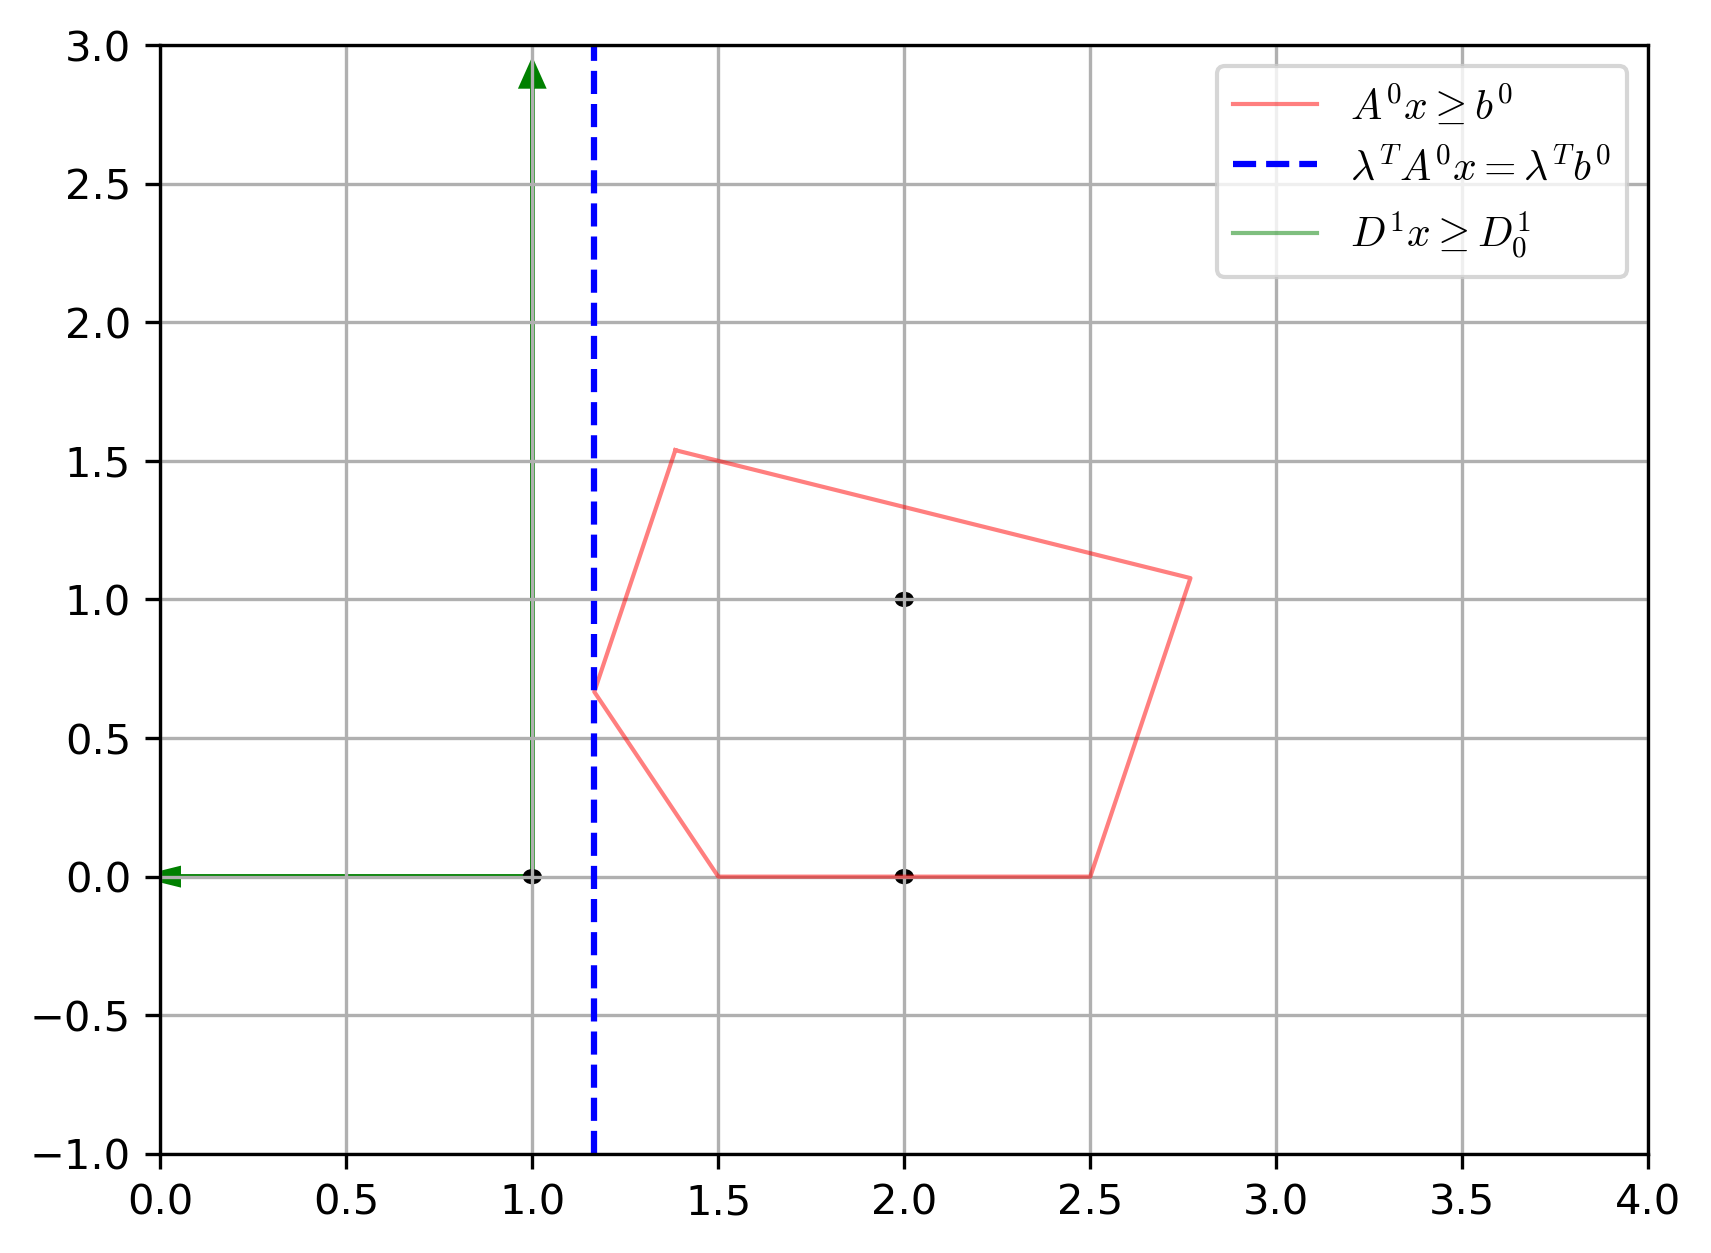

In [7]:
# now plot the polyhedron, the cut, and the cut loosened to the closest point in disjunctive constraints
p = Polyhedron2D(A=-A0, b=-b0)  # negative because we use Ax >= b but grumpy assumes Ax <= b
d = Polyhedron2D(A=-D1, b=-D1_0)
f = Figure()
f.add_polyhedron(p, color='red', show_int_points=True, label="$A^0x \geq b^0$")
f.add_line(alpha, beta, p.xlim, p.ylim, linestyle='dashed', color='blue',
           label="$\lambda^T A^0x = \lambda^T b^0$")
f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")
f.set_ylim(p.ylim)
f.set_xlim(p.xlim)
f.show(wait_for_click=False, filename='p.png')

# Perturb the branched LP to make it feasible with cut still working

In [8]:
# relax our constraints that are responsible for the infeasibility
c2.rhs = 1
c3.rhs = 0

# push the changes to mdl
mdl.update()

# get the model as np arrays
A1 = mdl.getA().toarray()
b1 = np.array([c.rhs for c in mdl.getConstrs()])

# resolve to prove we're feasible again
mdl.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 2 columns and 10 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0000000e+00   1.750000e+00   0.000000e+00      0s
       1   -1.3846154e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.384615385e+00


# Regenerate, flip, and tighten infeasibility cut to disjunctive constraints

In [9]:
# recalculate the infeasibility cut \lambda A^1x >= \lambda^T b^1
alpha, beta = (np.array([cert]) @ A1)[0], np.dot(cert, b1)  
print(f"cut after regenerating: {alpha}x >= {beta}")  # this is the cut after regenerating

# get the closest point in the bound constraints to the cut
# this is wrong figure out tomorrow
x_star = np.zeros((2,))
for i, v in enumerate([x, y]):
    x_star[i] = v.lb if alpha[i] < 0 else v.ub if alpha[i] > 0 else 0

# get the new right hand side tight at this point
new_rhs = np.dot(alpha, x_star)

# print the inequality as it should be applied to the disjunctive term
print(f"cut after regenerating, flipping, and tightening: {-alpha}x >= {-new_rhs}")

cut after regenerating: [6. 0.]x >= 1.0
cut after regenerating, flipping, and tightening: [-6. -0.]x >= -6.0


# Plot the perturbed polyhedron and the parameterized infeasibility cut

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/3580191379.py:3: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(p, color='red', show_int_points=True, label="$A^1x \geq b^1$")
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/3580191379.py:8: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")


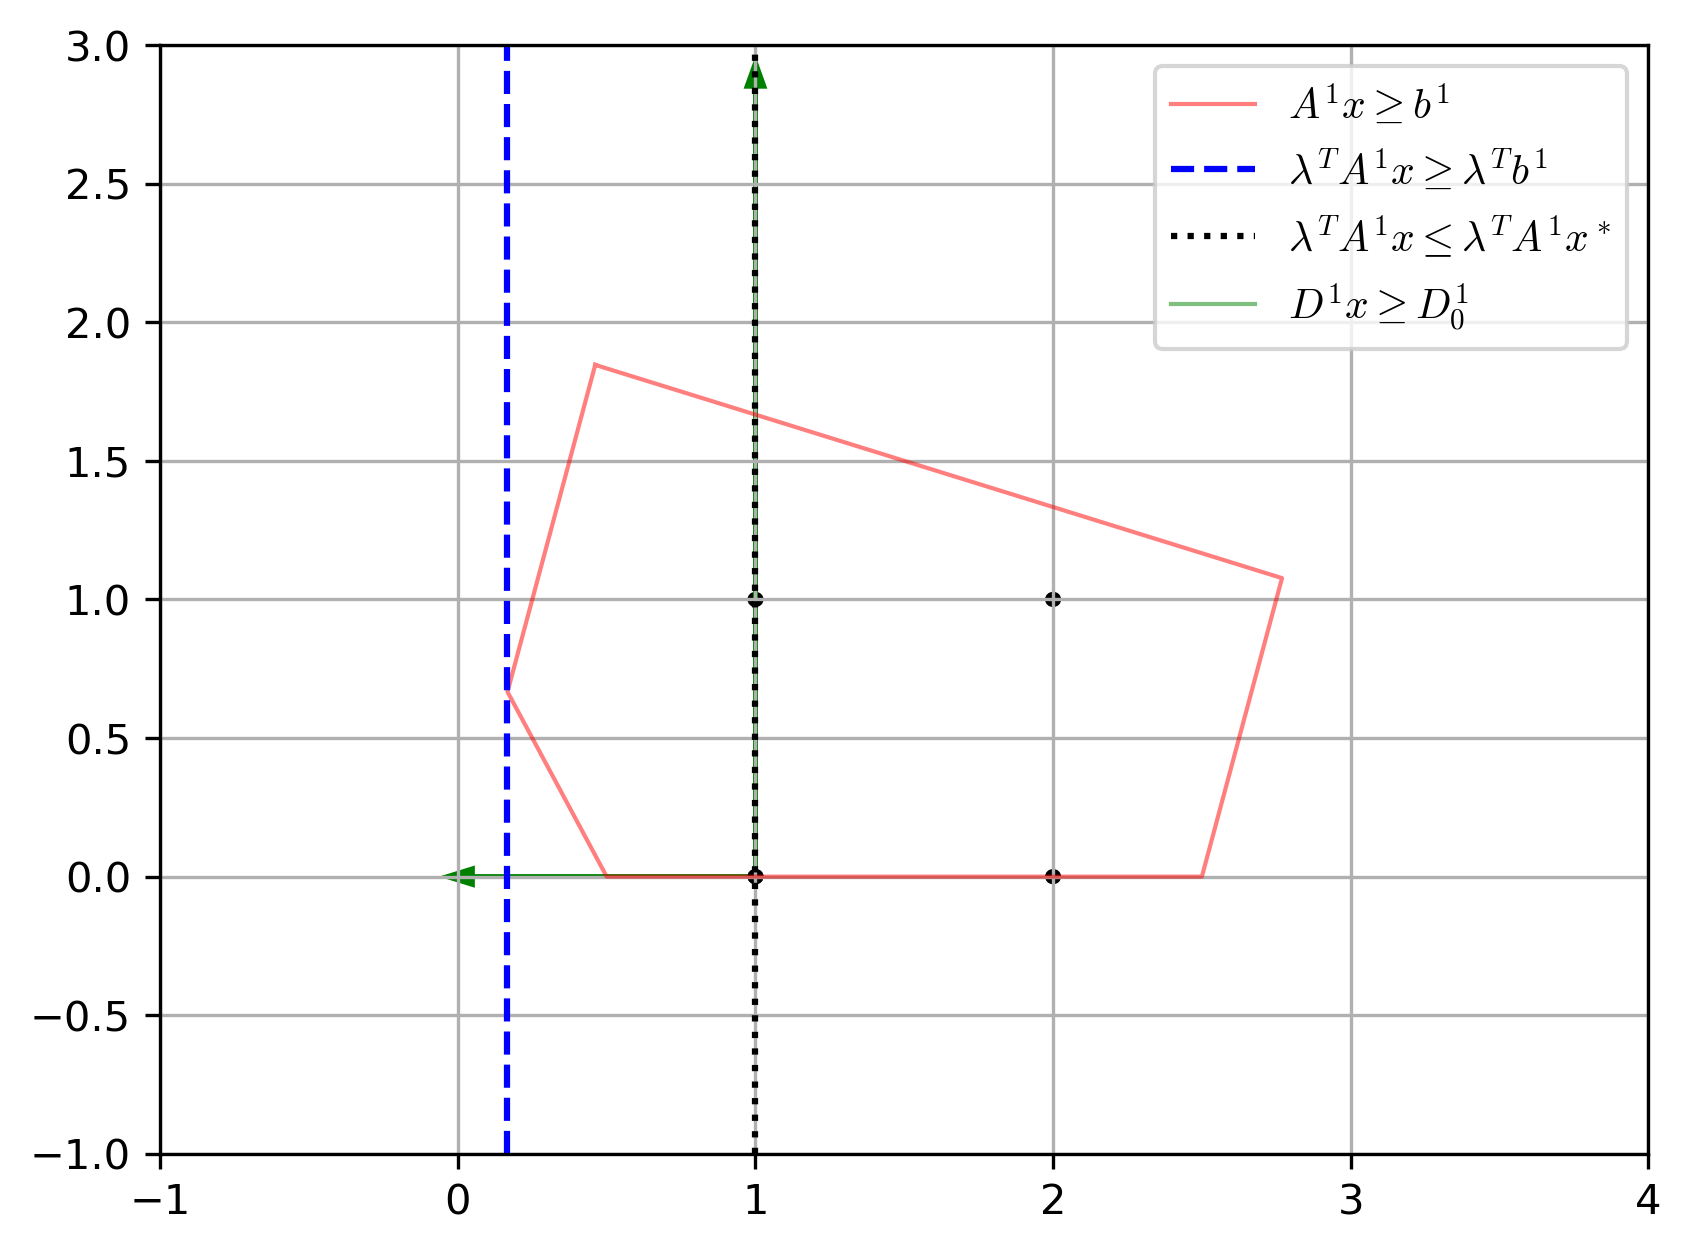

In [10]:
p = Polyhedron2D(A=-A1, b=-b1)  # negative because we use Ax >= b but grumpy assumes Ax <= b
f = Figure()
f.add_polyhedron(p, color='red', show_int_points=True, label="$A^1x \geq b^1$")
f.add_line(alpha, beta, p.xlim, p.ylim, linestyle='dashed', color='blue',
           label="$\lambda^T A^1x \geq \lambda^T b^1$")
f.add_line(alpha, new_rhs, p.xlim, p.ylim, linestyle='dotted', color='black',
           label="$\lambda^T A^1x \leq \lambda^T A^1x^*$")
f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")
f.set_ylim(p.ylim)
f.set_xlim(p.xlim)
f.show(wait_for_click=False, filename='p_perturbed.png')

# Plot VPCs and interactions when parameterizing with the FarkasDual cut

## Here we don't get a cut at all

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/3843119399.py:3: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(p, color='red', show_int_points=True, label="$A^1x \geq b^1$")
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/3843119399.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")


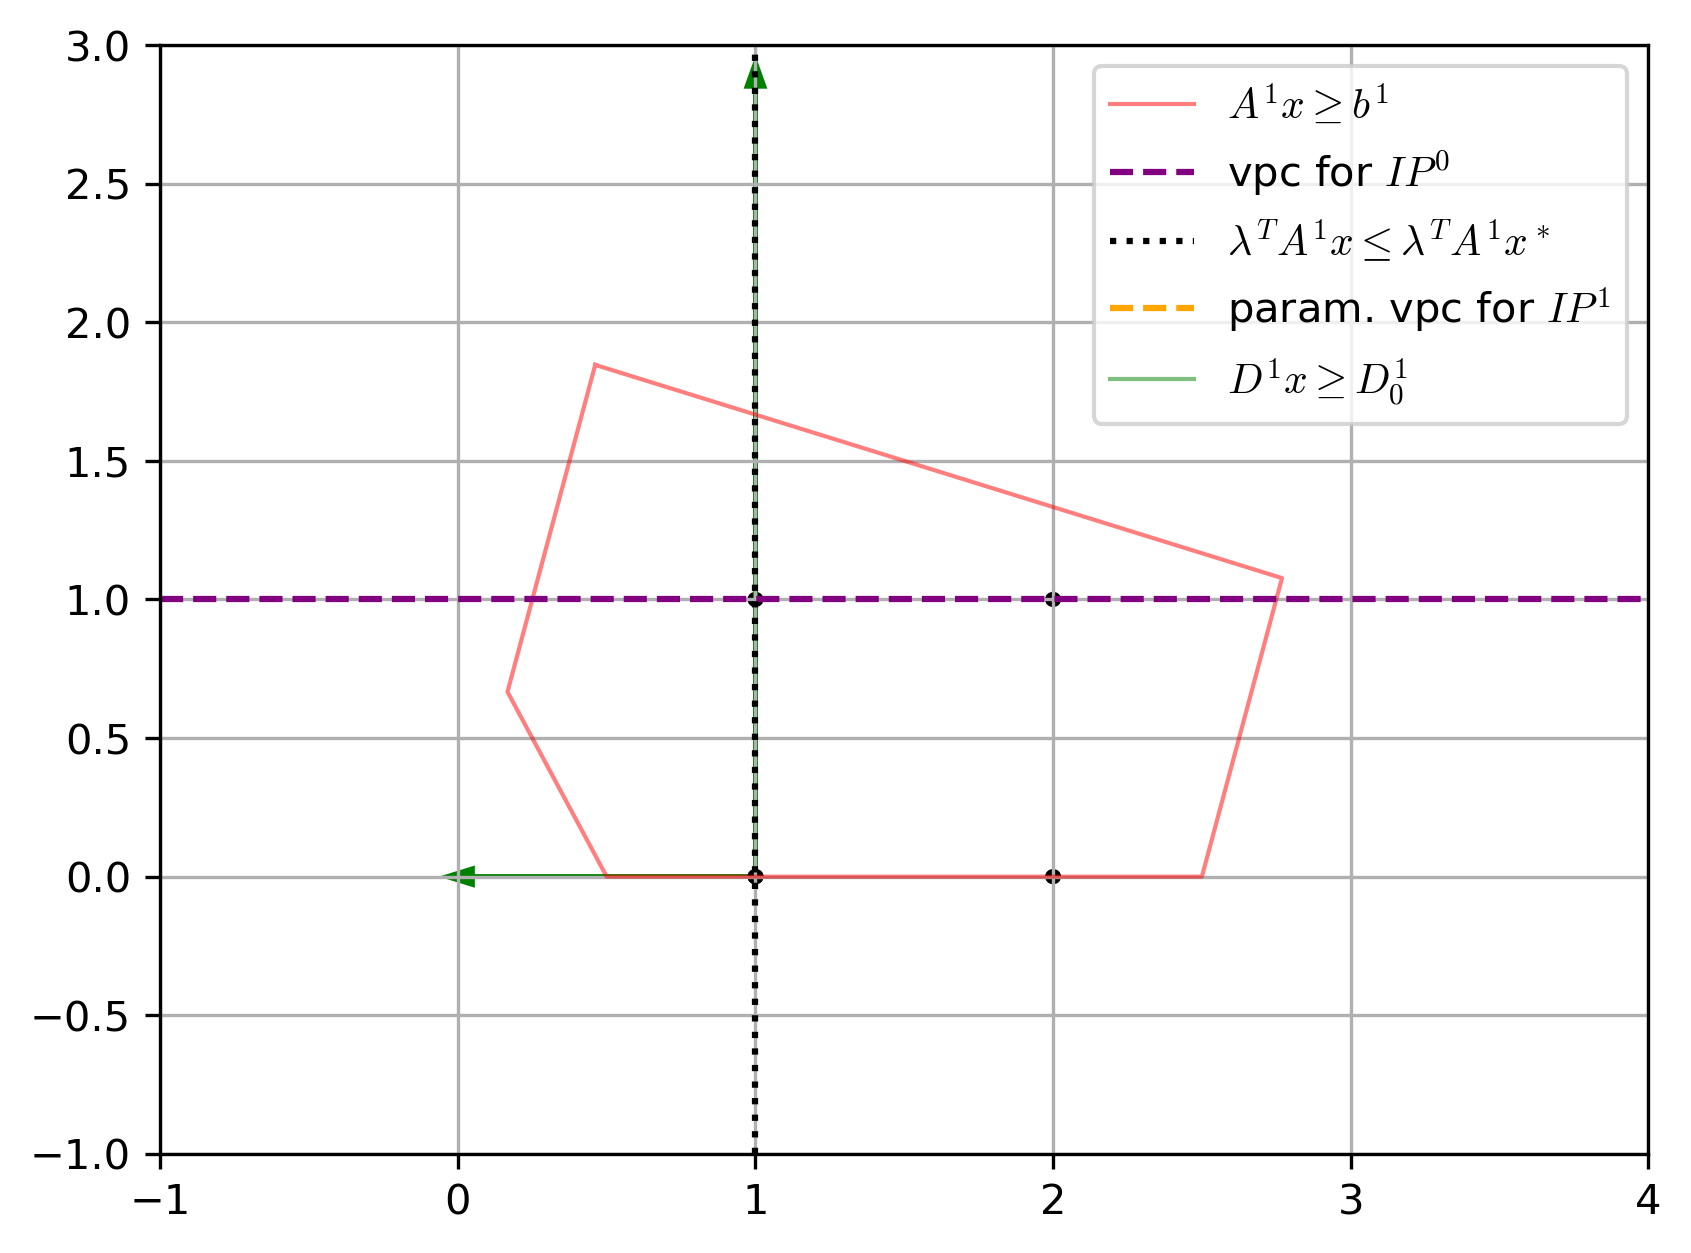

In [11]:
p = Polyhedron2D(A=-A1, b=-b1)  # negative because we use Ax >= b but grumpy assumes Ax <= b
f = Figure()
f.add_polyhedron(p, color='red', show_int_points=True, label="$A^1x \geq b^1$")
f.add_line(np.array([0, -1]), -1, p.xlim, p.ylim, linestyle='dashed', color='purple',
           label="vpc for $IP^0$")
f.add_line(alpha, new_rhs, p.xlim, p.ylim, linestyle='dotted', color='black',
           label="$\lambda^T A^1x \leq \lambda^T A^1x^*$")
f.add_line(np.array([0, 1]), 10, p.xlim, p.ylim, linestyle='dashed', color='orange',
           label="param. vpc for $IP^1$")
f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")
f.set_ylim(p.ylim)
f.set_xlim(p.xlim)
f.show(wait_for_click=False, filename='p_perturbed.png')

## Here we get a weak cut

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/2410220844.py:3: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(p, color='red', show_int_points=True, label="$A^1x \geq b^1$")
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/2410220844.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")


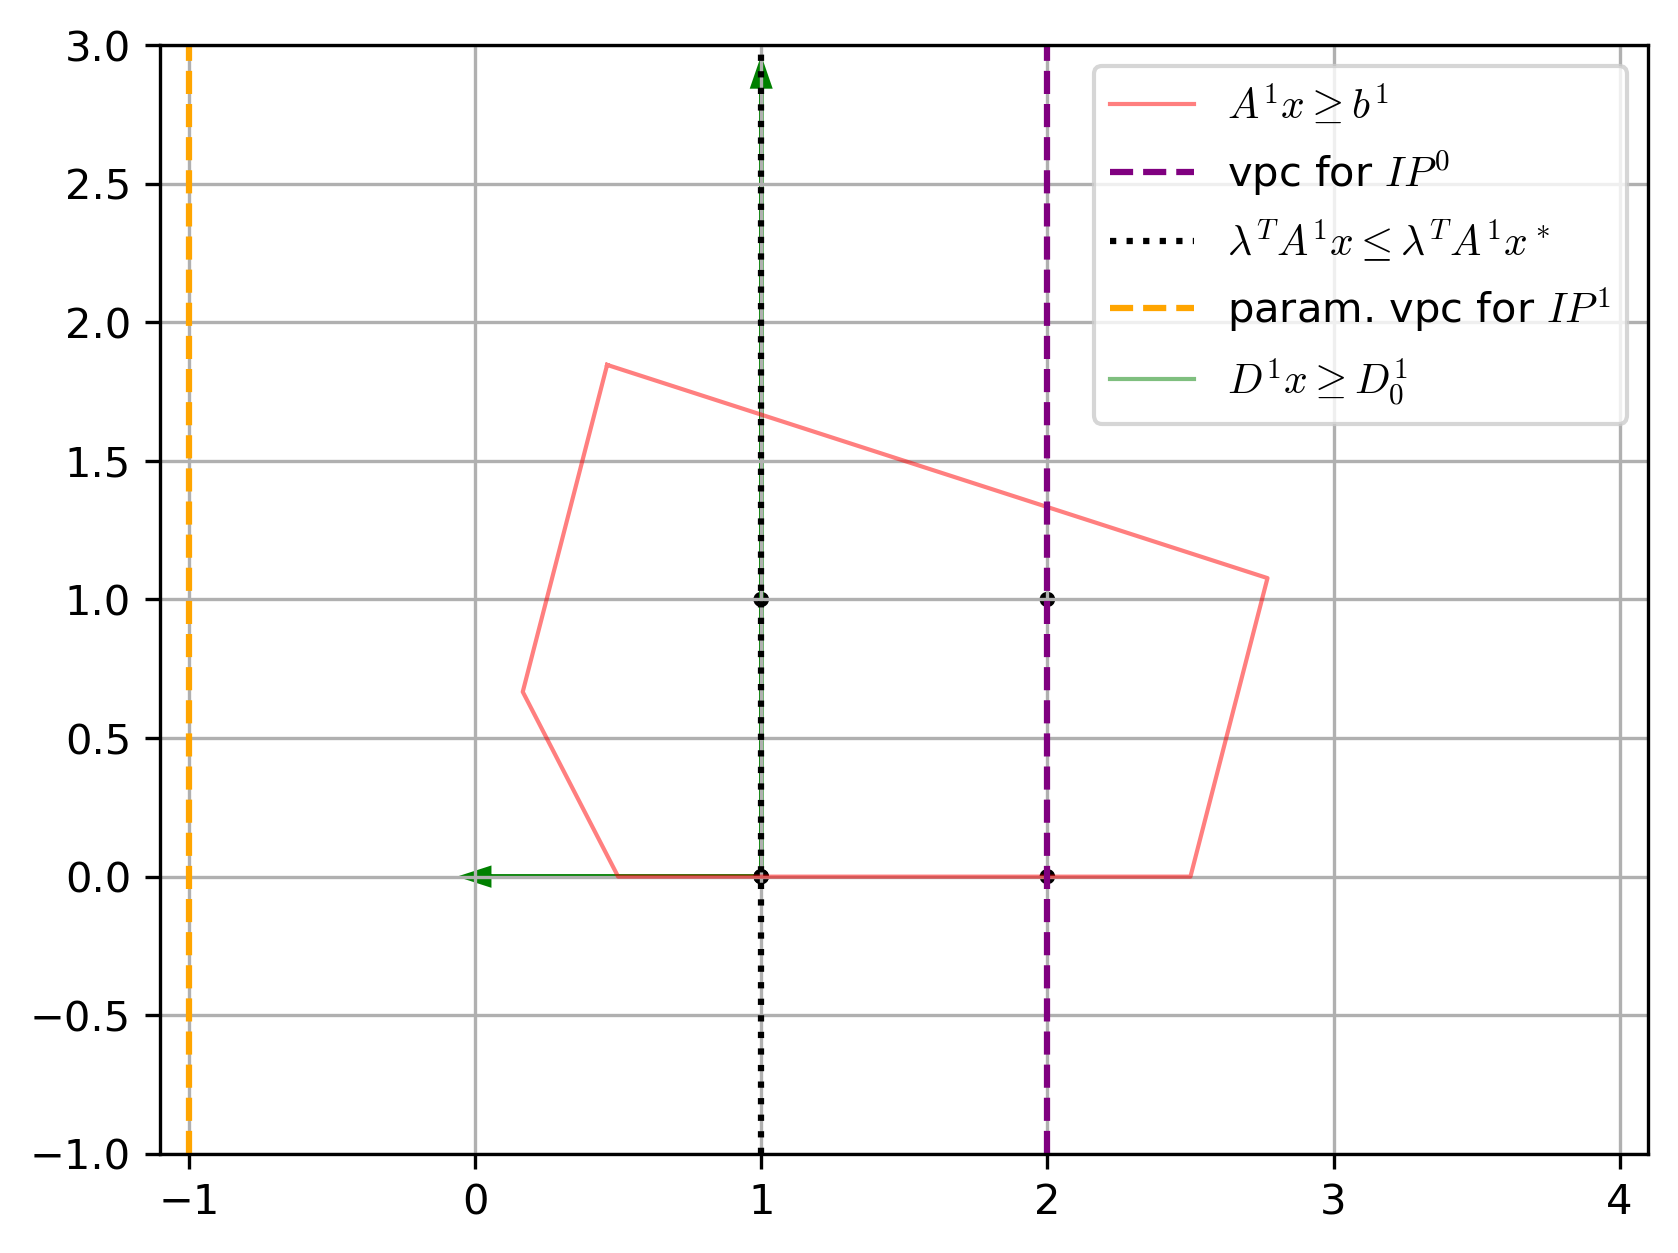

In [12]:
p = Polyhedron2D(A=-A1, b=-b1)  # negative because we use Ax >= b but grumpy assumes Ax <= b
f = Figure()
f.add_polyhedron(p, color='red', show_int_points=True, label="$A^1x \geq b^1$")
f.add_line(np.array([1, 0]), 2, p.xlim, p.ylim, linestyle='dashed', color='purple',
           label="vpc for $IP^0$")
f.add_line(alpha, new_rhs, p.xlim, p.ylim, linestyle='dotted', color='black',
           label="$\lambda^T A^1x \leq \lambda^T A^1x^*$")
f.add_line(np.array([1, 0]), -1, p.xlim, p.ylim, linestyle='dashed', color='orange',
           label="param. vpc for $IP^1$")
f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")
f.set_ylim(p.ylim)
f.set_xlim((-1.1, 4.1))
f.show(wait_for_click=False, filename='p_perturbed.png')

In [13]:
# It's even harder when we don't know where to place the FarkasDual Cut

In [14]:
# rotate c3 15 degrees counterclockwise
mdl.chgCoeff(c3, x, 1)
mdl.chgCoeff(c3, y, 0)
c3.rhs = 3/4

# push the changes to mdl
mdl.update()

# get the model as np arrays
A1 = mdl.getA().toarray()
b1 = np.array([c.rhs for c in mdl.getConstrs()])

# resolve to prove we're feasible again
mdl.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 2 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.000000000e+00


# Regenerate, flip, and tighten infeasibility cut to disjunctive constraints

In [15]:
# recalculate the infeasibility cut \lambda A^1x >= \lambda^T b^1
alpha, beta = (np.array([cert]) @ A1)[0], np.dot(cert, b1)  
print(f"cut after regenerating: {alpha}x >= {beta}")  # this is the cut after regenerating

# get the closest point in the bound constraints to the cut
# this is wrong figure out tomorrow
x_star = np.zeros((2,))
for i, v in enumerate([x, y]):
    x_star[i] = v.lb if alpha[i] < 0 else v.ub if alpha[i] > 0 else 0
# x_star = np.array([1, 0])

# get the new right hand side tight at this point
new_rhs = np.dot(alpha, x_star)

# print the inequality as it should be applied to the disjunctive term
print(f"cut after regenerating, flipping, and tightening: {-alpha}x >= {-new_rhs}")

cut after regenerating: [3. 1.]x >= 1.75
cut after regenerating, flipping, and tightening: [-3. -1.]x >= -inf


/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/3146647761.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(p, color='red', show_int_points=True, label="$A^1x \geq b^1$")
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_94687/3146647761.py:7: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")


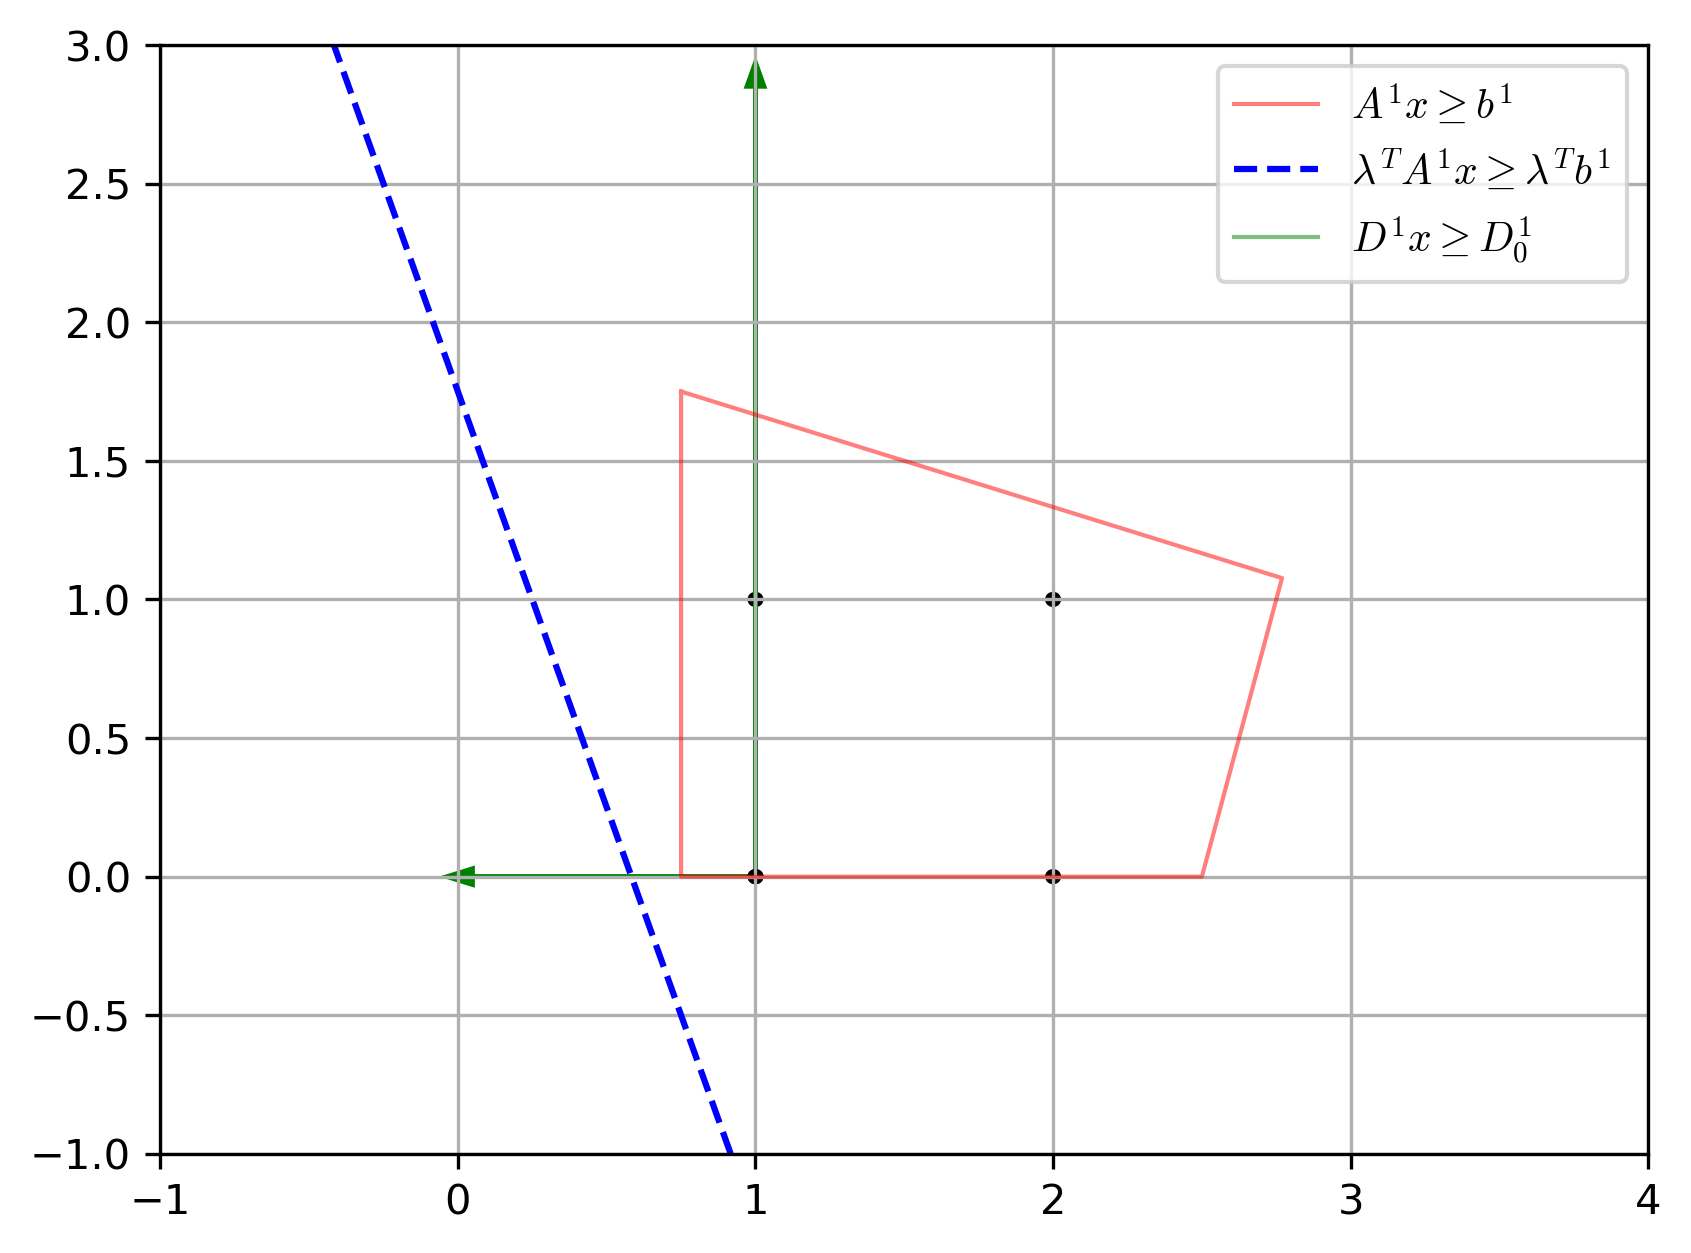

In [16]:
# Plot the perturbed polyhedron and the parameterized infeasibility cut
p = Polyhedron2D(A=-A1, b=-b1)  # negative because we use Ax >= b but grumpy assumes Ax <= b
f = Figure()
f.add_polyhedron(p, color='red', show_int_points=True, label="$A^1x \geq b^1$")
f.add_line(alpha, beta, p.xlim, p.ylim, linestyle='dashed', color='blue',
           label="$\lambda^T A^1x \geq \lambda^T b^1$")
f.add_polyhedron(d, color='green', show_int_points=True, label="$D^1x \geq D^1_0$")
f.set_ylim(p.ylim)
f.set_xlim(p.xlim)
f.show(wait_for_click=False, filename='p_perturbed.png')

In [ ]:
# if we could find a basis for a basic solution that includes the nonzero terms of farkasDual, we could find a certificate that yields the VPC
# for that to do any good, though, we would need for the reason we don't work well to be because many terms change their infeasibility status